### Regression and Classification with the Ames Housing Data

#### Overveiw

The project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) to determine the best properties to buy and re-sell. Specifically, the project aims to identify the characteristics of residential houses that estimate the sale price and the cost-effectiveness of doing renovations.

#### Objective

There are three components to the project:

1. Estimate the sale price of properties based on their "fixed" characteristics, such as neighborhood, lot size, number of stories, etc.
2. Estimate the value of possible changes and renovations to properties from the variation in sale price not explained by the fixed characteristics. The goal is to estimate the potential return on investment (and how much you should be willing to pay contractors) when making specific improvements to properties.
3. Determine the features in the housing data that best predict "abnormal" sales (forclosures, etc.).





# 1. Estimating the value of homes from fixed characteristics.

---
In the first section, There are three components to identify the value of homes from fixed characteristics:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Based on the data description, the list of fixed and renovatable characteristics is listed below:

Fixed features:

'MSSubClass', 'MSZoning','LotFrontage', 'LotArea', 'Street', 'Alley','LotShape', 'LandContour', 'Utilities', 'LotConfig','LandSlope','Neighborhood','BldgType', 'HouseStyle','YearBuilt', 'YearRemodAdd', 'RoofStyle','MasVnrArea', 
'Foundation','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','Functional', 'Fireplaces','GarageType', 'GarageYrBlt','GarageFinish', 'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch',
'ScreenPorch', 'PoolArea','MiscFeature', 'MiscVal','MoSold', 'YrSold','SaleType'


Renovatable features:

'Condition1', 'Condition2','OverallQual', 'OverallCond','RoofMatl', 'Exterior1st', 'Exterior2nd', 
'MasVnrType','ExterQual', 'ExterCond','BsmtQual', 'BsmtCond','BsmtFinType1','BsmtFinType2','Heating', 'HeatingQC',
'CentralAir', 'Electrical','KitchenQual','FireplaceQu','GarageQual', 'GarageCond',
'PavedDrive','PoolQC','Fence','SaleCondition'

# Import the necessary libraries

In [10]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm, boxcox
from scipy.special import boxcox1p, inv_boxcox1p

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score, regression,mean_squared_error
from sklearn.preprocessing import StandardScaler


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



# EDA

In [11]:
# import the data use read.csv
house = pd.read_csv('./housing.csv')

In [38]:
# create a dataframe from data
house = pd.DataFrame(house)
house

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,WD,Normal,175000
1444,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1445,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1446,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,4,2010,WD,Normal,142125


In [13]:
house = house.drop(['Id'],axis=1)

In [14]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

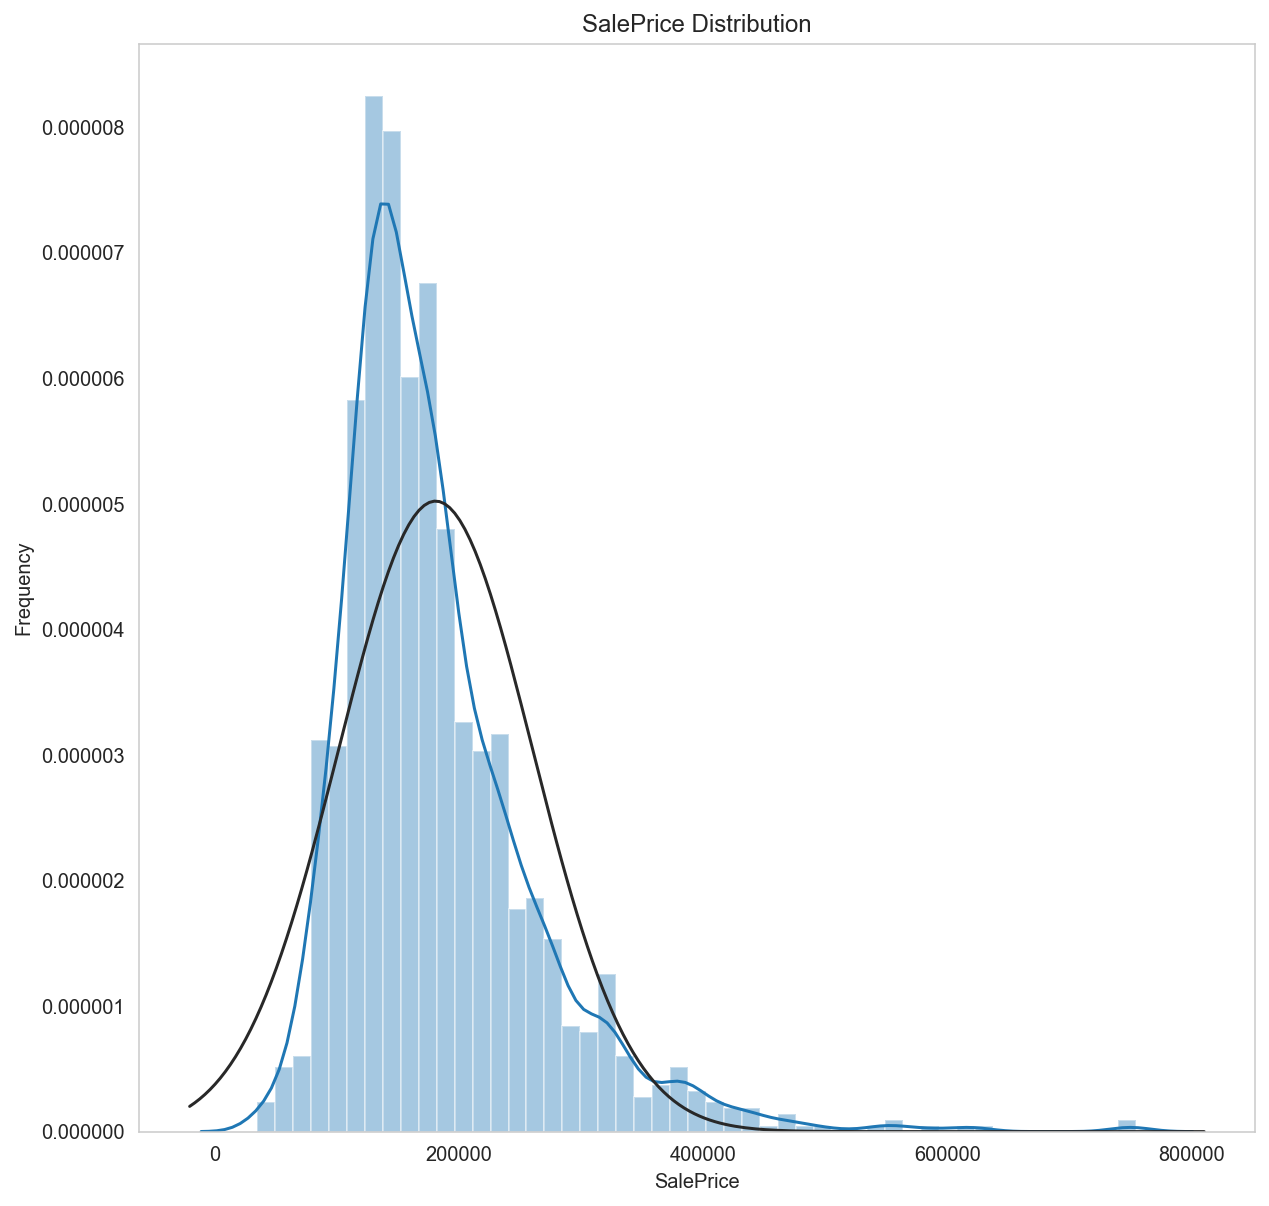

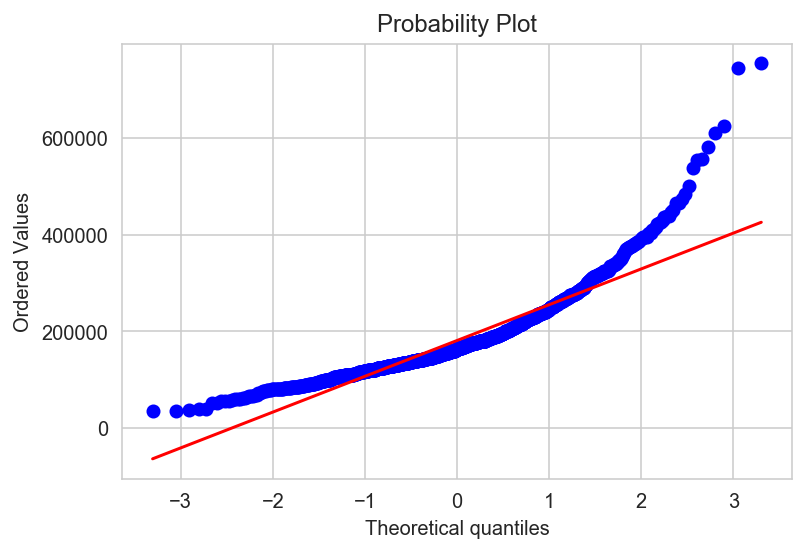

In [15]:
f, ax = plt.subplots(figsize=(10,10)) # define figure size
sns.distplot(house['SalePrice'], fit = norm) # choose displot to see distribution
ax.grid(False) # remove a grid in grapgh
ax.set(ylabel="Frequency") # set y label description
ax.set(xlabel = "SalePrice") # set x label description 
ax.set(title = "SalePrice Distribution") # set the title of graph

fig = plt.figure()
res = stats.probplot(house['SalePrice'], plot=plt)
plt.show()

The distribution of target variable(SalePrice) is right skewed. The linear regression model 

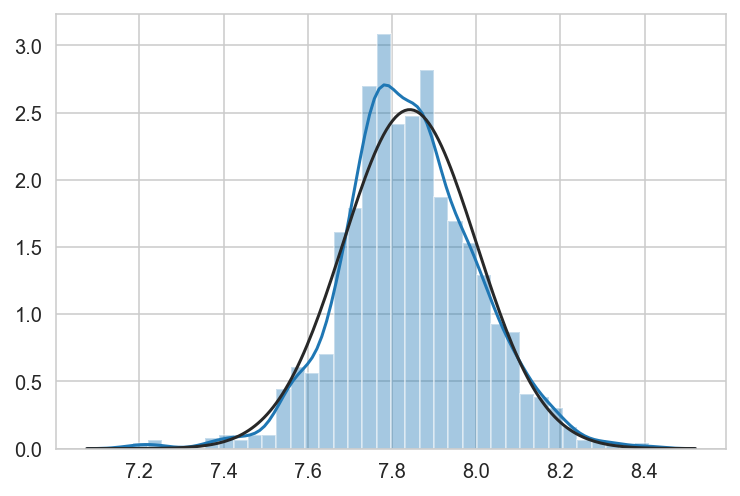

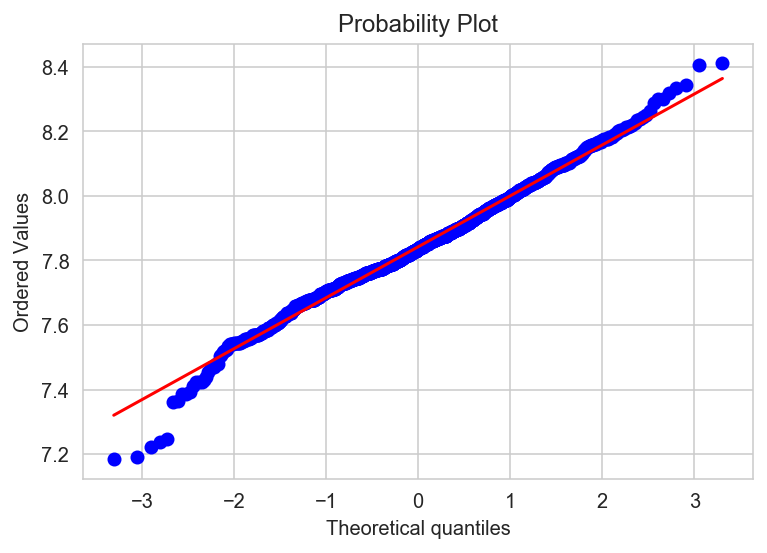

In [16]:
#transform the data using box-cox
sample_transformed, lambd = stats.boxcox(house['SalePrice'])
#plot the distribution curve and QQ-plot for transformed data
sns.distplot(sample_transformed, fit = norm)
plt.show()
fig = stats.probplot(sample_transformed, plot=plt)
plt.show()

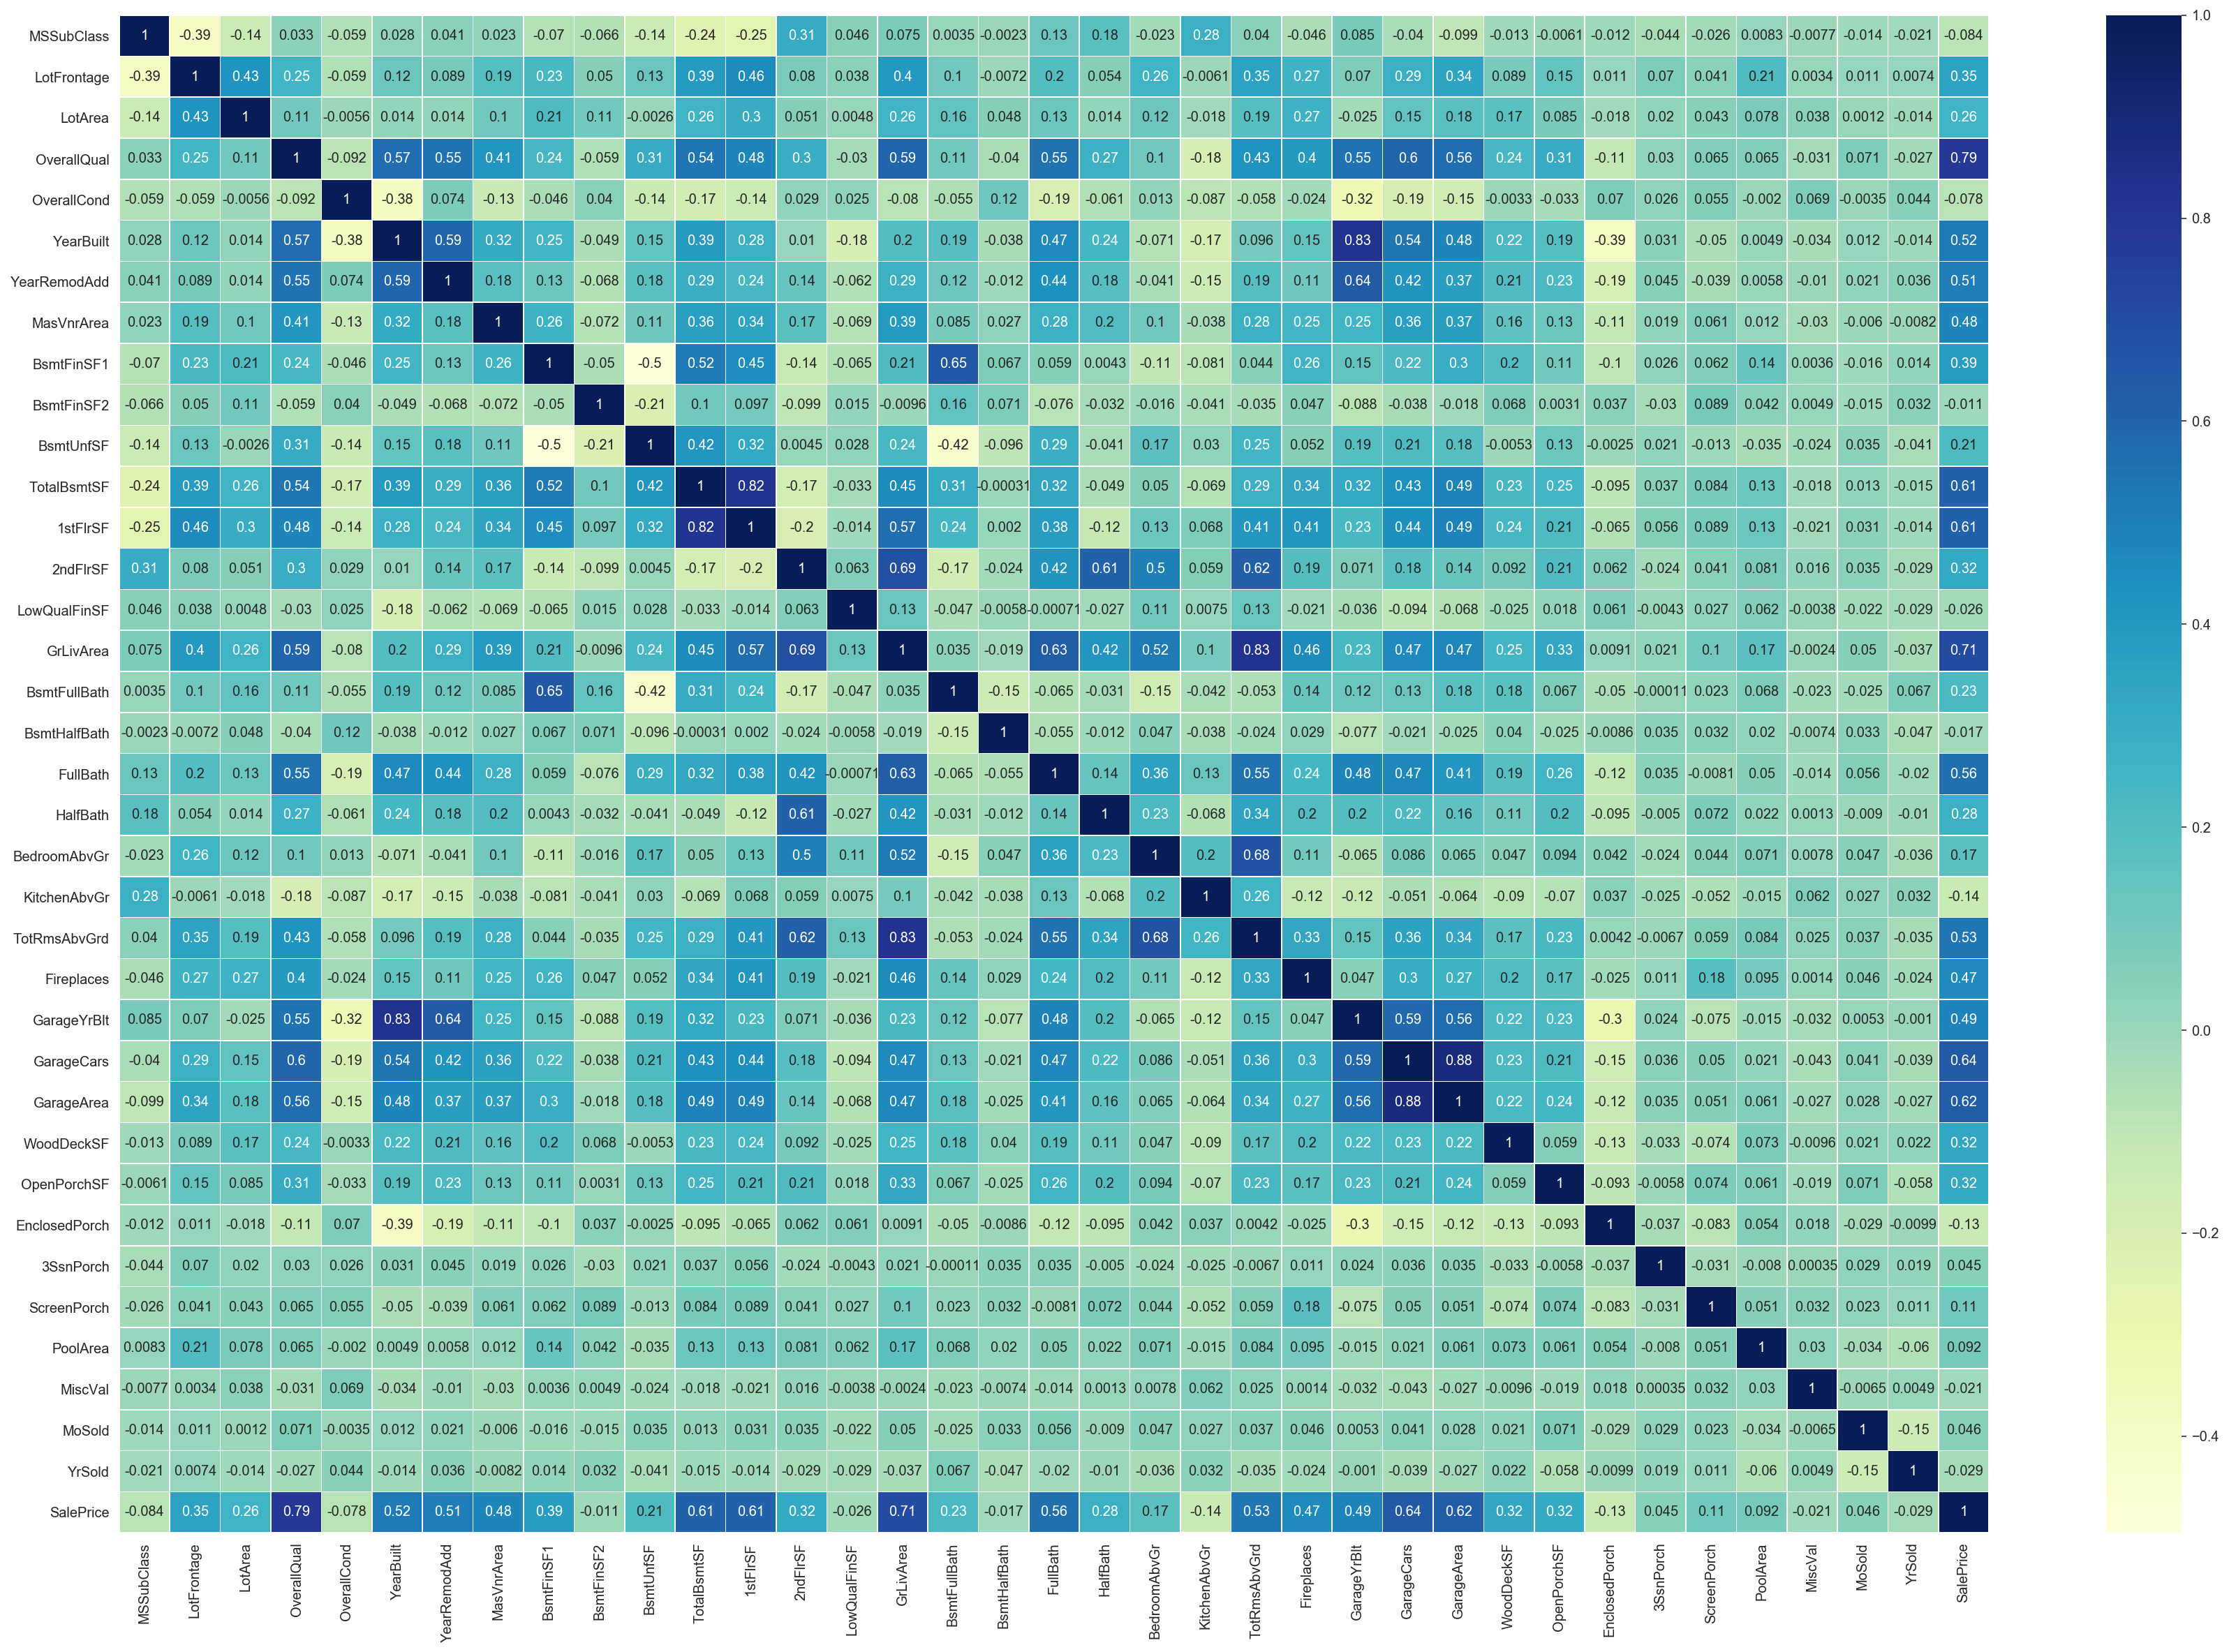

In [17]:
correlation_matrix =house.corr() #assign the correltion of each feature to correlation_matrix
f, ax = plt.subplots(figsize=(30,20)) # set a figure size
sns.heatmap(correlation_matrix, annot= True, linewidths=.3, cmap="YlGnBu") #draw a heatmap using sns.heatmap

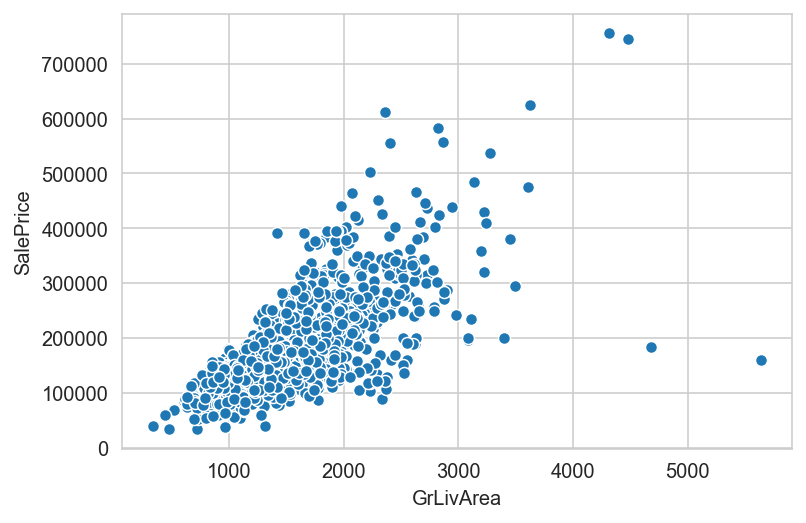

In [18]:
sns.scatterplot(house['GrLivArea'],house['SalePrice'])

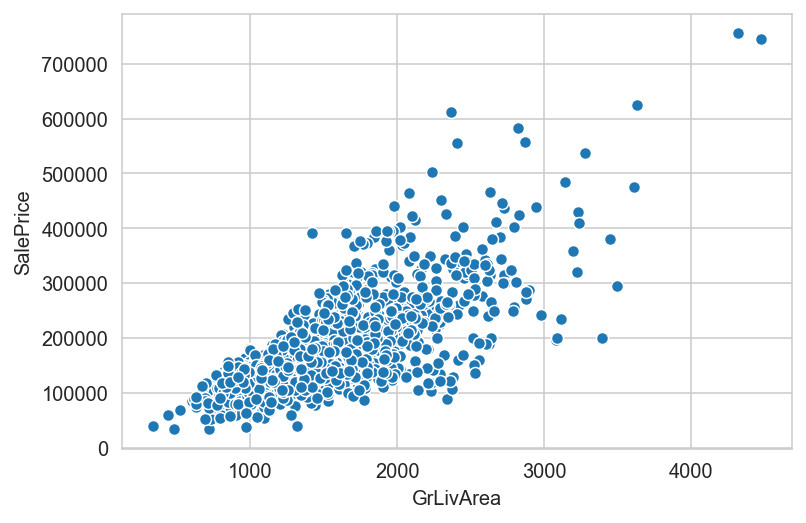

In [19]:
house = house.drop(house[(house['GrLivArea']>4000) & (house['SalePrice'] < 200000)].index)
sns.scatterplot(house['GrLivArea'],house['SalePrice'])

## Missing value

In this section, missing values were handled by data type and evaluation of each feature.

|features|missing percentage|desceiption|Impute|meaning|
|---|---|---|---|---|
|PoolQC        |  99.520548|Pool quality| None | No pool|
|MiscFeature   |  96.301370|Miscellaneous feature not covered in other categories|  None | No Miscellaneous feature |
|Alley         |  93.767123|Type of alley access to property|  None |No alley access|
|Fence         |  80.753425|Fence quality |  None | No fence|
|FireplaceQu   |  47.260274|Fireplace quality|  None | No Fireplace|
|LotFrontage   |  17.739726|Linear feet of street connected to property|  0 | No Street or the property is next to the street|
|GarageCond    |   5.547945|Garage condition| None | No Garage|
|GarageType    |   5.547945|Garage location| None | No Garage|
|GarageYrBlt   |   5.547945|Year garage was built| None | Unknown year built or no Garage|
|GarageFinish  |   5.547945|Interior finish of the garage| None | No Garage|
|GarageQual    |   5.547945|Garage quality| None | No Garage|
|BsmtExposure  |   2.602740|Refers to walkout or garden level walls|  None |No Basement|
|BsmtFinType2  |   2.602740|Rating of basement finished area (if multiple types)|  None |No Basement|
|BsmtFinType1  |   2.534247|Rating of basement finished area|  None |No Basement|
|BsmtCond      |   2.534247|the general condition of the basement|  None |No Basement|
|BsmtQual      |   2.534247|the height of the basement|  None | No Basement|
|MasVnrArea    |   0.547945|Masonry veneer area in square feet|  0 | No Masonry veneer|
|MasVnrType    |   0.547945|Masonry veneer type|  None | No Masonry veneer|
|Electrical    |   0.068493|Electrical system |  SBrkr| Standard Circuit Breakers & Romex|

There are 19 features that contains missing value. the percentage is shown in the table above. I decide to use description of data and data characteristic to define the missing value of each feature.
1. If the feature is categorical data, I'll impute it as None which mean there do not have these feature in the property.
2. If the feature is numeric data, I'll impute it with 0 as there do not have these features in the property.
3. If the feature is mandatory for property, I'll impute it with statistical value.

In [20]:
# have a look of the missing value and Dtype of each column
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1458 non-null int64
MSZoning         1458 non-null object
LotFrontage      1199 non-null float64
LotArea          1458 non-null int64
Street           1458 non-null object
Alley            91 non-null object
LotShape         1458 non-null object
LandContour      1458 non-null object
Utilities        1458 non-null object
LotConfig        1458 non-null object
LandSlope        1458 non-null object
Neighborhood     1458 non-null object
Condition1       1458 non-null object
Condition2       1458 non-null object
BldgType         1458 non-null object
HouseStyle       1458 non-null object
OverallQual      1458 non-null int64
OverallCond      1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
RoofStyle        1458 non-null object
RoofMatl         1458 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 non-

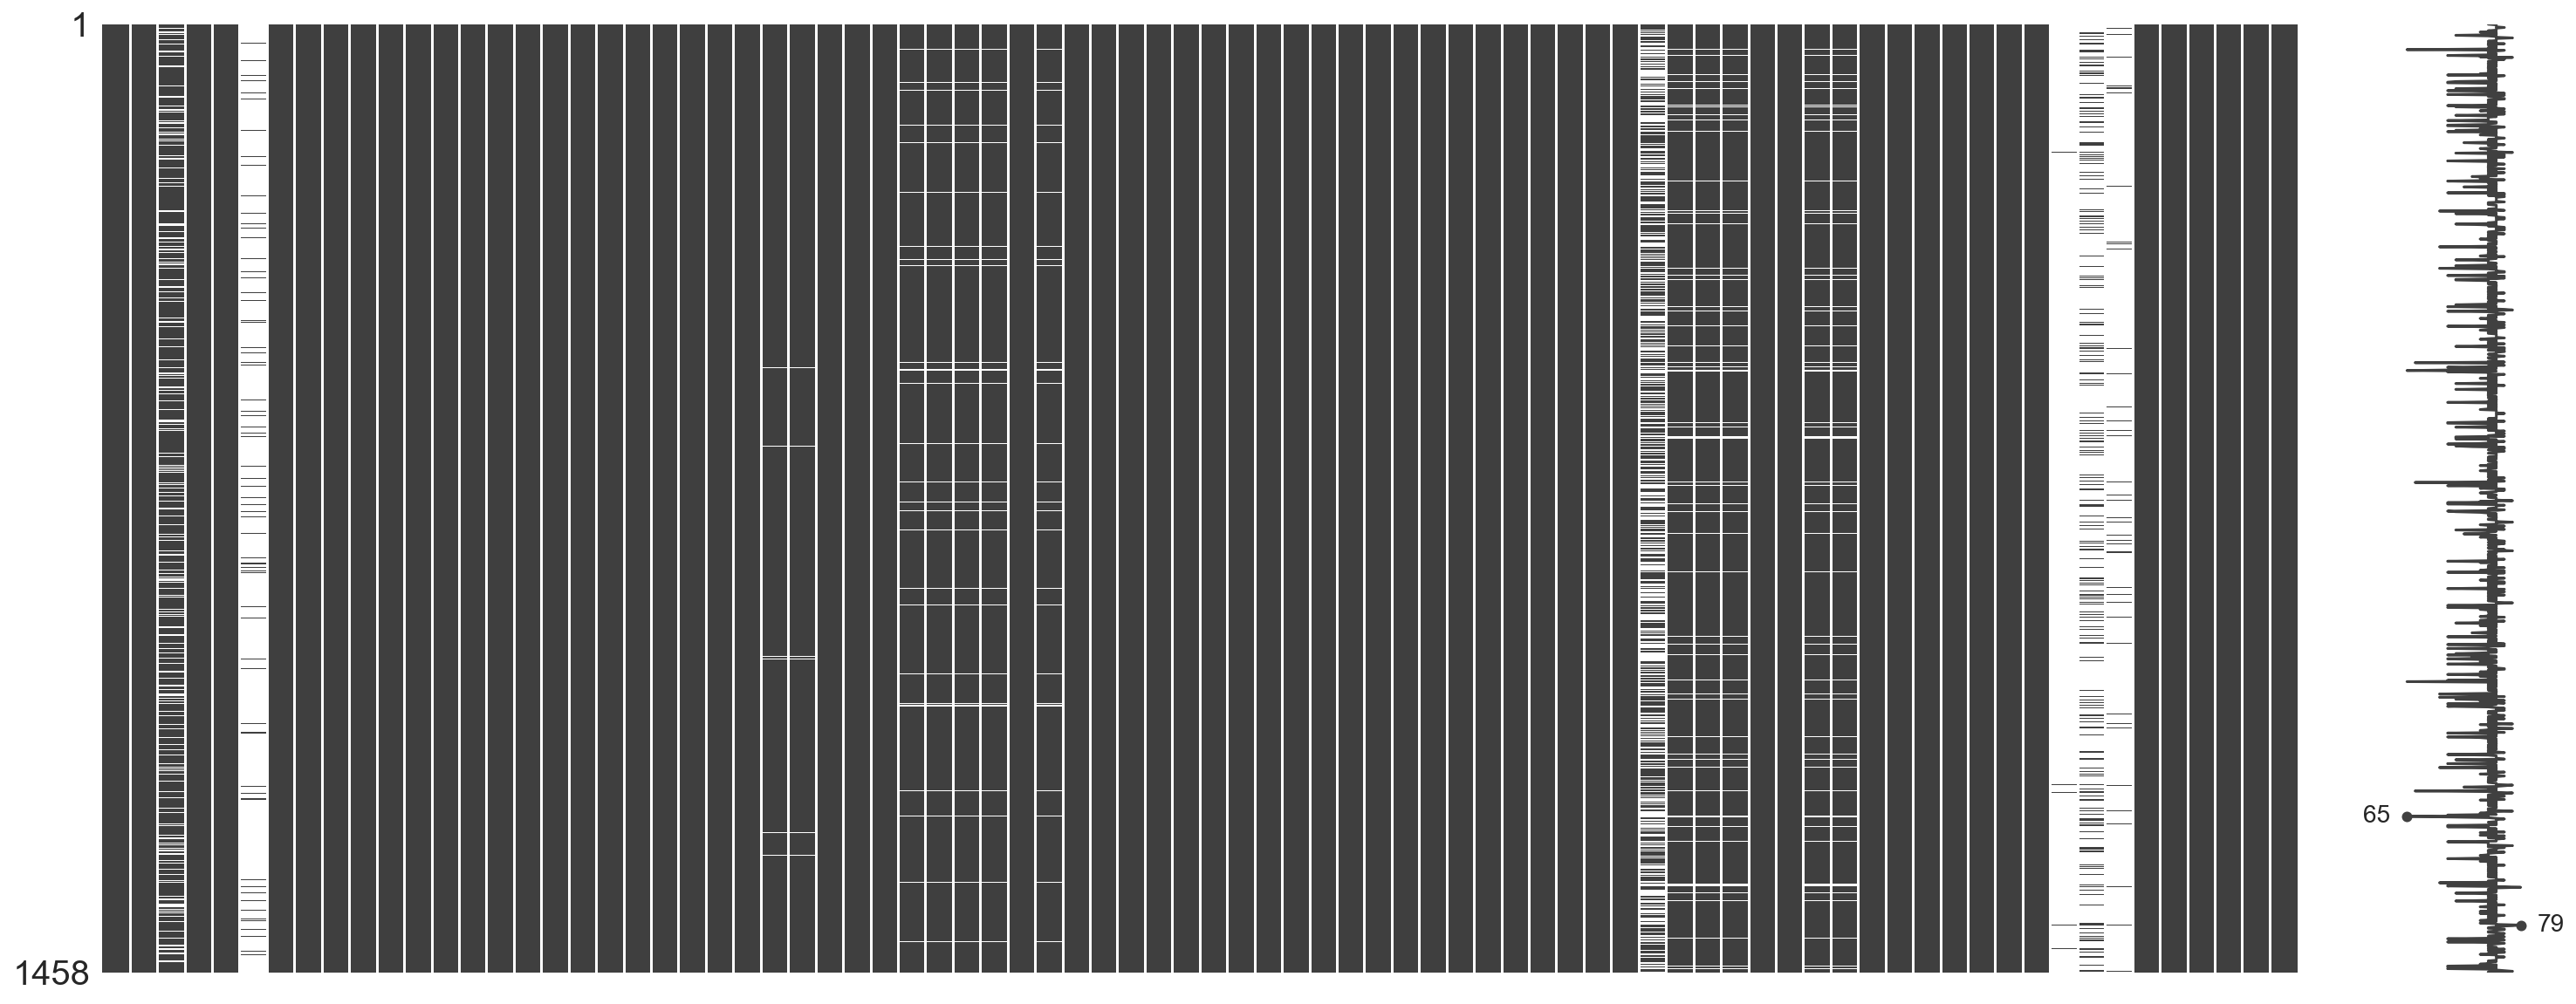

In [21]:

# there is a lot of missing value as see from the graph below
import missingno as msno
msno.matrix(house)

In [22]:
# find a a percentage of missing value
Na_percent= house.isnull().sum()/len(house)*100
Na_percent= Na_percent.sort_values(ascending= False).head(20)
Na_percent

Na_table=pd.DataFrame({'MissingRate': Na_percent})
print(Na_table)
print(Na_table.shape)

              MissingRate
PoolQC          99.588477
MiscFeature     96.296296
Alley           93.758573
Fence           80.727023
FireplaceQu     47.325103
LotFrontage     17.764060
GarageType       5.555556
GarageCond       5.555556
GarageFinish     5.555556
GarageQual       5.555556
GarageYrBlt      5.555556
BsmtFinType2     2.606310
BsmtExposure     2.606310
BsmtQual         2.537723
BsmtCond         2.537723
BsmtFinType1     2.537723
MasVnrArea       0.548697
MasVnrType       0.548697
Electrical       0.068587
RoofMatl         0.000000
(20, 1)


According to the table above, 19 features have the missing values. I will have a look to the description to find out what the value should be to impute the data to each column. Firstly, the objective of the project is to buy the resident properly to find the cost effectiveness of the property. So, I will delete the properties which is non-resident properties.

Text(0.5, 1.0, 'Percentage of missing data by feature')

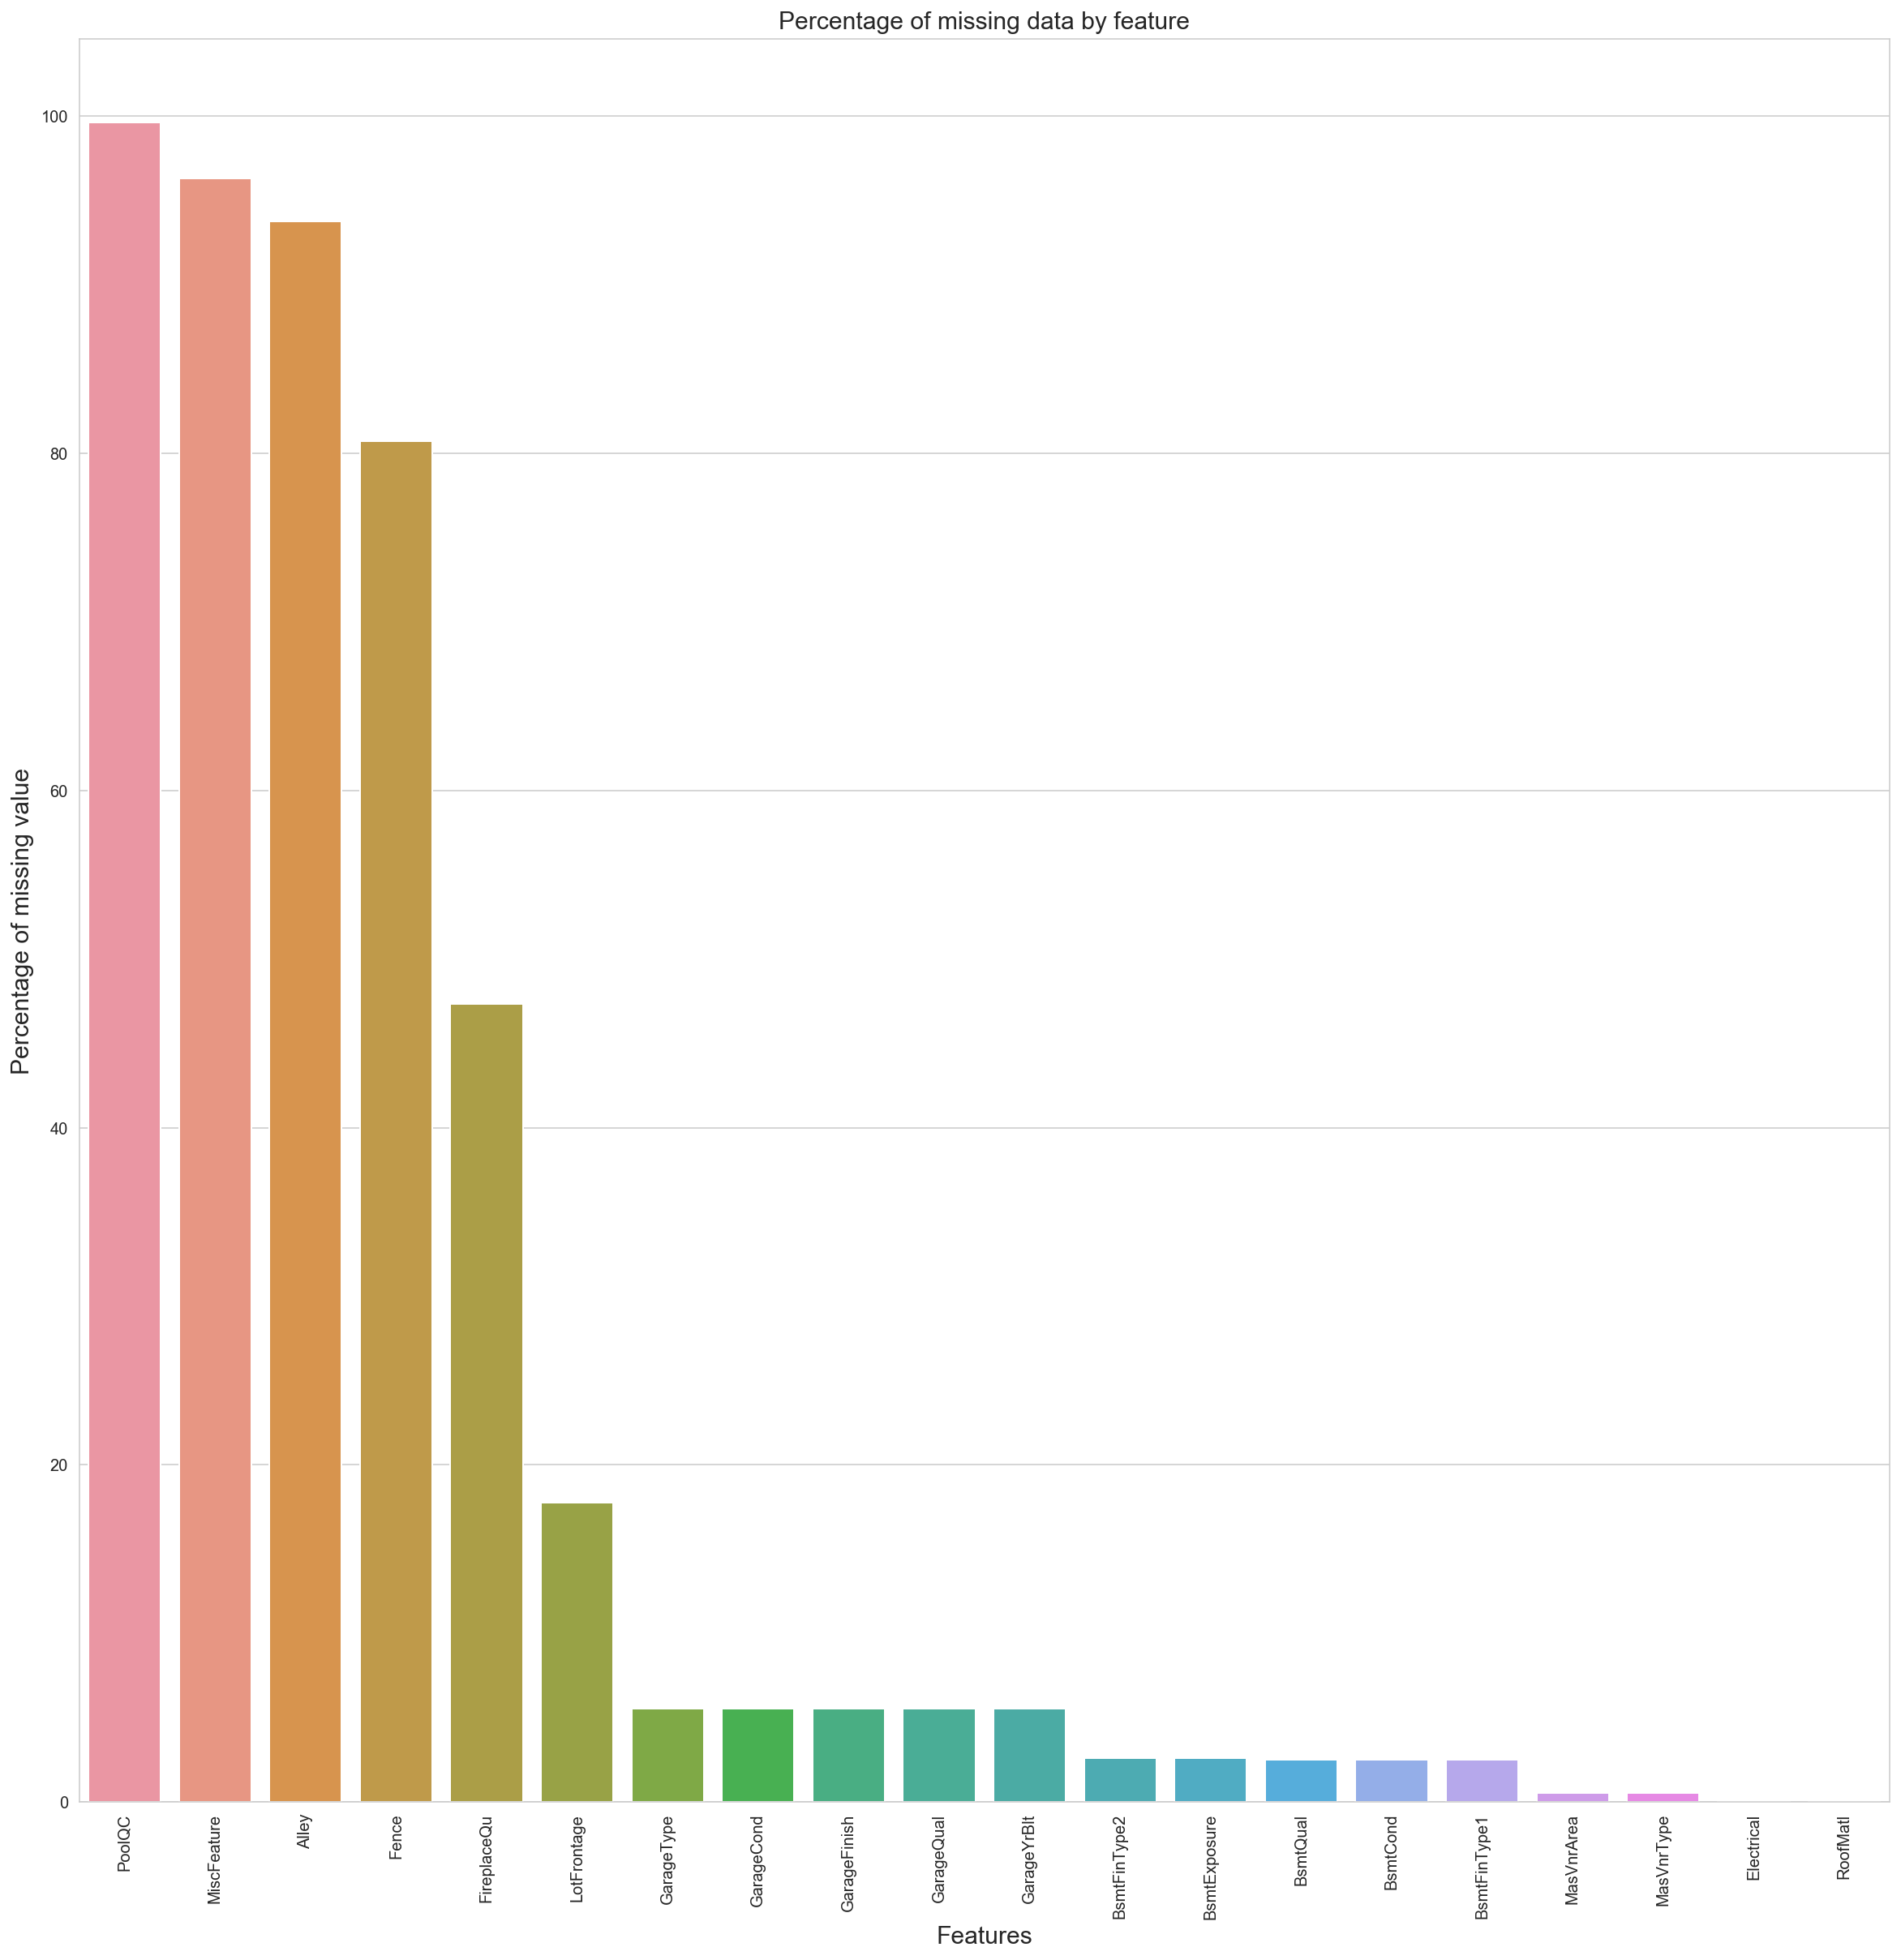

In [23]:
# plot the visualization graph for the missing value
f ,ax = plt.subplots(figsize=(20,20))
sns.barplot(x= Na_table.index, y= Na_percent)
ax.set_xticklabels(Na_table.index, rotation = 90)
ax.set_ylabel("Percentage of missing value", fontsize= 15)
ax.set_xlabel("Features",fontsize= 15)
ax.set_title("Percentage of missing data by feature", fontsize = 15)

In [24]:
# As the data identify the residential place with MSZoning columns, have a look at the MSZoning columns  
house['MSZoning'].value_counts()

RL         1149
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [25]:
# delete the non residential property from the data set
house= house.loc[house['MSZoning'] != "C (all)" , :]
# As the C category is the type of property for commercial, I classify it as non residential property.
house.shape
# I deleted 10 rows which are the commercial property out of the data frame

(1448, 80)

|features|missing percentage|desceiption|Impute|meaning|
|---|---|---|---|---|
|PoolQC        |  99.520548|Pool quality| None | No pool|
|MiscFeature   |  96.301370|Miscellaneous feature not covered in other categories|  None | No Miscellaneous feature |
|Alley         |  93.767123|Type of alley access to property|  None |No alley access|
|Fence         |  80.753425|Fence quality |  None | No fence|
|FireplaceQu   |  47.260274|Fireplace quality|  None | No Fireplace|
|LotFrontage   |  17.739726|Linear feet of street connected to property|  0 | No Street or the property is next to the street|
|GarageCond    |   5.547945|Garage condition| None | No Garage|
|GarageType    |   5.547945|Garage location| None | No Garage|
|GarageYrBlt   |   5.547945|Year garage was built| None | Unknown year built or no Garage|
|GarageFinish  |   5.547945|Interior finish of the garage| None | No Garage|
|GarageQual    |   5.547945|Garage quality| None | No Garage|
|BsmtExposure  |   2.602740|Refers to walkout or garden level walls|  None |No Basement|
|BsmtFinType2  |   2.602740|Rating of basement finished area (if multiple types)|  None |No Basement|
|BsmtFinType1  |   2.534247|Rating of basement finished area|  None |No Basement|
|BsmtCond      |   2.534247|the general condition of the basement|  None |No Basement|
|BsmtQual      |   2.534247|the height of the basement|  None | No Basement|
|MasVnrArea    |   0.547945|Masonry veneer area in square feet|  0 | No Masonry veneer|
|MasVnrType    |   0.547945|Masonry veneer type|  None | No Masonry veneer|
|Electrical    |   0.068493|Electrical system |  SBrkr| Standard Circuit Breakers & Romex|

In [26]:
# In the Eletrical column, I found that there is only 1 missing value
#I decide to fill it with the most frequency type(mode) which is SBrkr
house.Electrical.value_counts()

SBrkr    1326
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [27]:
# For the year garage was built, I decide to impute to None which is unknown year built
house.GarageYrBlt.value_counts()

2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    48
          ..
1942.0     2
1906.0     1
1927.0     1
1908.0     1
1933.0     1
Name: GarageYrBlt, Length: 96, dtype: int64

In [28]:
# For the Linear feet of street connected to property, I decided to impute it to zero 
house.LotFrontage.value_counts()

60.0     139
70.0      70
80.0      69
50.0      55
75.0      53
        ... 
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 110, dtype: int64

In [29]:
#For the height of the basement, the value is categorical values. So, I will impute it with None
house.BsmtQual.value_counts()

TA    639
Gd    618
Ex    119
Fa     35
Name: BsmtQual, dtype: int64

In [30]:
#For the Masonry veneer area in square feet, I decided to impute mode to the missing value which is '0'
house.MasVnrArea.value_counts()

0.0      851
72.0       8
180.0      8
108.0      8
120.0      7
        ... 
415.0      1
293.0      1
259.0      1
562.0      1
621.0      1
Name: MasVnrArea, Length: 325, dtype: int64

In [31]:
#fill null values in Electrical's column with 'SBrkr' 
house['Electrical'].fillna(value= 'SBrkr', inplace= True)
#After having a look at the description of each feature, there are 2 categories 
#which should fill Null values with the numeric values: LotFrontage and  MasVnrArea
#the rest should fill with 'None' as there are no values.
#For example, PoolQc and Fence columns, fill none mean there are no pool or fence in the property

#fill null values in LotFrontage's column with 0.0 means Linear feet of street connected to property is 0.0
house['LotFrontage'].fillna(value= 0.0, inplace= True)

#fill null values in MasVnrArea's column with 0.0 means Masonry veneer area in square feet is 0.0
house['MasVnrArea'].fillna(value= 0.0, inplace= True)



# fill the rest of the value will 'None'
house.fillna(value= 'None',inplace=True)


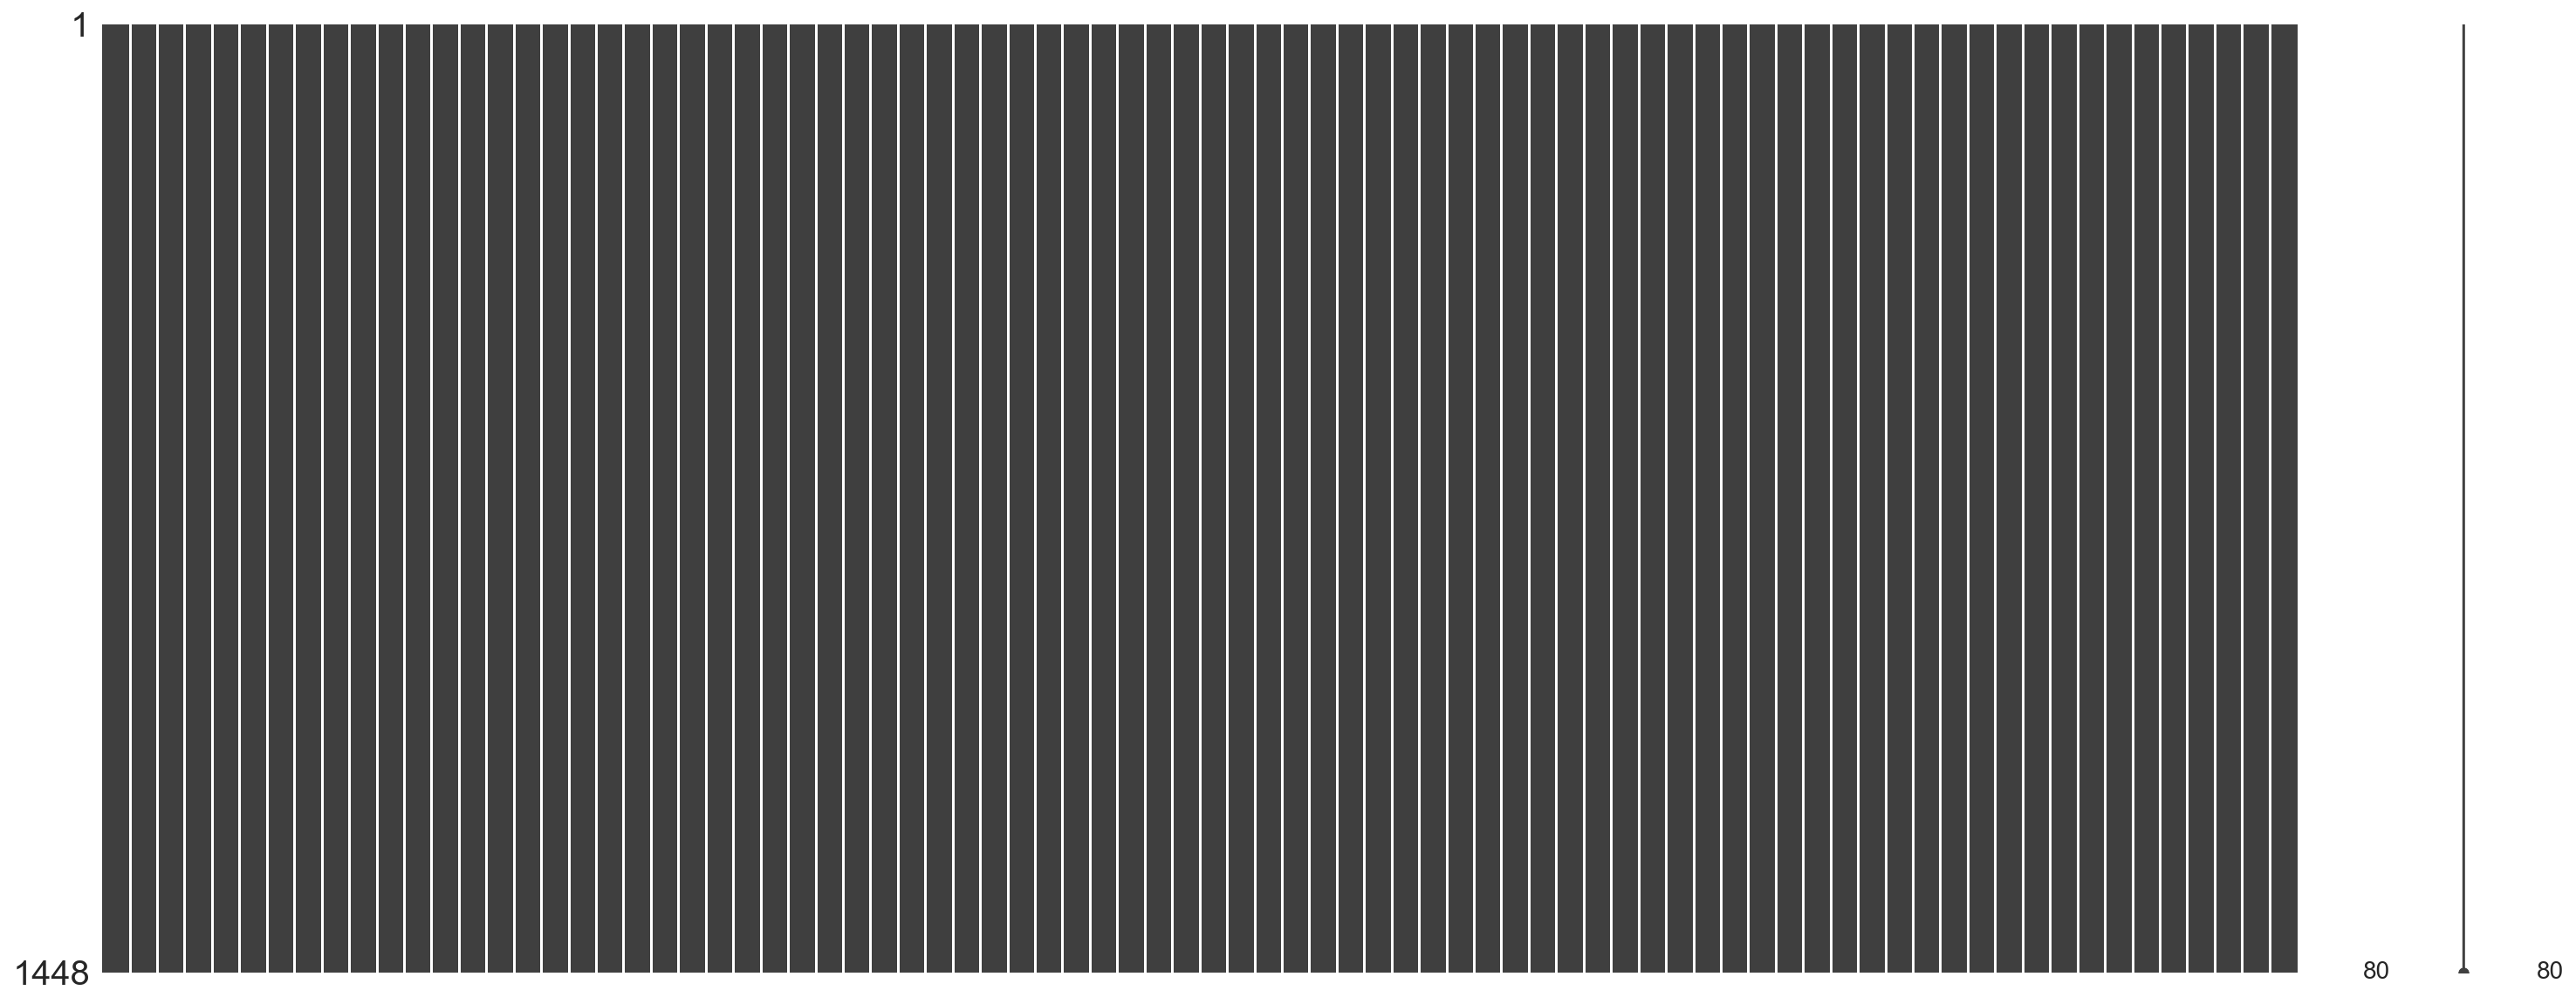

In [32]:
msno.matrix(house)# the graph below shows that all the columns is filled by the None which means there are no spcefic features in the house and the rest is filled by 0 which means there are no features in  these columns

In [34]:
#After cleaning the data, I decide to reset the index of the data to make it more properly
house.reset_index(inplace=True, drop=True)

In [35]:
house.SalePrice

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1443    175000
1444    210000
1445    266500
1446    142125
1447    147500
Name: SalePrice, Length: 1448, dtype: int64

# Baseline

In [37]:
house.SalePrice.mean()

181667.75966850828

# Feature Engineering

## Dependent Variable

## Categorical and Numeric features

In [610]:
house.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,...,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000
mean,56.899171,57.313536,10466.557320,6.109116,5.582873,1971.543508,1985.017956,102.895718,440.319061,46.935083,...,94.666436,46.120166,21.566298,3.437845,15.117403,2.450276,43.425414,6.313536,2007.812845,181667.759669
std,42.294074,34.034675,9889.736752,1.366182,1.107883,30.013718,20.548786,179.525427,433.091749,161.930868,...,125.573201,64.255564,60.875583,29.436993,55.929193,38.341214,497.977672,2.694751,1.327056,79229.096063
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,20.000000,41.000000,7538.750000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,50.000000,63.000000,9491.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.250000,2004.000000,165.250000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214125.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2188.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [611]:
house.loc[:, "MSSubClass"]= house.loc[:, "MSSubClass"].astype('str') # Covert MSSubClass column to categorical value
house.loc[:, 'OverallQual']=house.loc[:, 'OverallQual'].astype('str')
house.loc[:, 'OverallCond']=house.loc[:, 'OverallCond'].astype('str')
house.loc[:, 'YrSold']=house.loc[:, 'YrSold'].astype('str')
house.loc[:, 'MoSold']=house.loc[:, 'MoSold'].astype('str')
house.loc[:, 'YearBuilt']=house.loc[:, 'YearBuilt'].astype('str')
house.loc[:, 'YearRemodAdd']=house.loc[:, 'YearRemodAdd'].astype('str')

In [612]:
numeric_col= house.dtypes[house.dtypes != "object"].index
numeric_col

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'SalePrice'],
      dtype='object')

In [613]:
skewness= stats.skew(house[numeric_col])
skew_col='skewness'
skewness_df= pd.DataFrame(data= skewness, index=numeric_col)
skewness_df.rename(columns={0:'skewness'},inplace= True)
skewness_df= skewness_df.sort_values('skewness', ascending= False)
print(skewness_df)

                skewness
MiscVal        24.379662
PoolArea       15.877154
LotArea        12.528779
3SsnPorch      10.250219
LowQualFinSF    9.221523
KitchenAbvGr    4.502820
BsmtFinSF2      4.230819
BsmtHalfBath    4.111437
ScreenPorch     4.108782
EnclosedPorch   3.135903
MasVnrArea      2.682862
OpenPorchSF     2.196760
SalePrice       1.904805
WoodDeckSF      1.535127
GrLivArea       1.014768
BsmtUnfSF       0.921983
1stFlrSF        0.885198
2ndFlrSF        0.810616
BsmtFinSF1      0.761135
HalfBath        0.671563
TotRmsAbvGrd    0.661997
Fireplaces      0.623543
BsmtFullBath    0.581673
TotalBsmtSF     0.504487
BedroomAbvGr    0.211471
GarageArea      0.112746
FullBath        0.032065
LotFrontage     0.007503
GarageCars     -0.342161


In [614]:
transform_feature = skewness_df.loc[abs(skewness_df['skewness'])>0.5]
transform_feature.index

Index(['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF',
       'KitchenAbvGr', 'BsmtFinSF2', 'BsmtHalfBath', 'ScreenPorch',
       'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'SalePrice', 'WoodDeckSF',
       'GrLivArea', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1',
       'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'BsmtFullBath',
       'TotalBsmtSF'],
      dtype='object')

In [615]:
from scipy.special import boxcox1p
skewed_features = transform_feature.index

# Lambda = 0.0
# for feature in skewed_features:
#     house[feature]=boxcox1p(house[feature],Lambda)
skewed_features= skewed_features.drop('SalePrice')

In [616]:

house[skewed_features]=np.log1p(house[skewed_features])

In [617]:
house.SalePrice

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1443    175000
1444    210000
1445    266500
1446    142125
1447    147500
Name: SalePrice, Length: 1448, dtype: int64

In [618]:
skewness= stats.skew(house[numeric_col])
skew_col='skewness'
skewness_df= pd.DataFrame(data= skewness, index=numeric_col)
skewness_df.rename(columns={0:'skewness'},inplace= True)
skewness_df= skewness_df.sort_values('skewness', ascending= False)
print(skewness_df)

                skewness
PoolArea       15.447800
3SsnPorch       7.693621
LowQualFinSF    7.578049
MiscVal         5.237842
BsmtHalfBath    3.939226
KitchenAbvGr    3.874646
ScreenPorch     3.147600
BsmtFinSF2      2.506229
EnclosedPorch   2.147237
SalePrice       1.904805
HalfBath        0.561329
MasVnrArea      0.494388
BsmtFullBath    0.410220
2ndFlrSF        0.294258
BedroomAbvGr    0.211471
Fireplaces      0.168715
WoodDeckSF      0.148016
GarageArea      0.112746
FullBath        0.032065
1stFlrSF        0.008573
LotFrontage     0.007503
OpenPorchSF    -0.028556
GrLivArea      -0.056193
TotRmsAbvGrd   -0.069189
LotArea        -0.181940
GarageCars     -0.342161
BsmtFinSF1     -0.626464
BsmtUnfSF      -2.181142
TotalBsmtSF    -5.155303


In [619]:
house['PoolArea'].value_counts()

0.000000    1442
6.253829       1
6.475433       1
6.320768       1
6.357842       1
6.605298       1
6.240276       1
Name: PoolArea, dtype: int64

In [620]:
fixed_features = ['MSSubClass', 'MSZoning','LotFrontage', 'LotArea', 'Street', 'Alley','LotShape',
                 'LandContour', 'Utilities', 'LotConfig','LandSlope','Neighborhood','BldgType', 'HouseStyle',
                 'YearBuilt', 'YearRemodAdd', 'RoofStyle','MasVnrArea', 'Foundation','BsmtExposure','BsmtFinSF1',
                 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea', 
                 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','BedroomAbvGr', 'KitchenAbvGr',
                 'TotRmsAbvGrd','Functional', 'Fireplaces','GarageType', 'GarageYrBlt','GarageFinish', 
                 'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 
                 'ScreenPorch', 'PoolArea','MiscFeature', 'MiscVal','MoSold', 'YrSold','SaleType']

renovatable_features = ['Condition1', 'Condition2','OverallQual', 'OverallCond','RoofMatl', 
                        'Exterior1st', 'Exterior2nd', 'MasVnrType','ExterQual', 
                        'ExterCond','BsmtQual', 'BsmtCond','BsmtFinType1','BsmtFinType2',
                        'Heating', 'HeatingQC', 'CentralAir', 'Electrical','KitchenQual',
                        'FireplaceQu','GarageQual', 'GarageCond', 'PavedDrive','PoolQC','Fence','SaleCondition']

In [621]:
fixed_df= house[fixed_features]
fixed_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscFeature,MiscVal,MoSold,YrSold,SaleType
0,60,RL,65.0,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,...,4.127134,0.000000,0.0,0.0,0.0,None,0.0,2,2008,WD
1,20,RL,80.0,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,...,0.000000,0.000000,0.0,0.0,0.0,None,0.0,5,2007,WD
2,60,RL,68.0,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,...,3.761200,0.000000,0.0,0.0,0.0,None,0.0,9,2008,WD
3,70,RL,60.0,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,...,3.583519,5.609472,0.0,0.0,0.0,None,0.0,2,2006,WD
4,60,RL,84.0,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,...,4.442651,0.000000,0.0,0.0,0.0,None,0.0,12,2008,WD


In [622]:
renovatable_df= house[renovatable_features]
renovatable_df.head()

,Condition1,Condition2,OverallQual,OverallCond,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,...,CentralAir,Electrical,KitchenQual,FireplaceQu,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,SaleCondition
0,Norm,Norm,7,5,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,...,Y,SBrkr,Gd,None,TA,TA,Y,None,None,Normal
1,Feedr,Norm,6,8,CompShg,MetalSd,MetalSd,None,TA,TA,...,Y,SBrkr,TA,TA,TA,TA,Y,None,None,Normal
2,Norm,Norm,7,5,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,...,Y,SBrkr,Gd,TA,TA,TA,Y,None,None,Normal
3,Norm,Norm,7,5,CompShg,Wd Sdng,Wd Shng,None,TA,TA,...,Y,SBrkr,Gd,Gd,TA,TA,Y,None,None,Abnorml
4,Norm,Norm,8,5,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,...,Y,SBrkr,Gd,TA,TA,TA,Y,None,None,Normal


# Modeling

In [623]:
clean_fixed_df = pd.get_dummies(fixed_df, drop_first=True)
print(clean_fixed_df.shape)

y = house['SalePrice']
X = clean_fixed_df

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3, random_state=42)


(1448, 419)


In [624]:
X.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,YrSold_2009,YrSold_2010,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,65.0,9.042040,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,...,0,0,0,0,0,0,0,0,0,1
1,80.0,9.169623,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
2,68.0,9.328212,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,0.0,...,0,0,0,0,0,0,0,0,0,1
3,60.0,9.164401,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,0.0,...,0,0,0,0,0,0,0,0,0,1
4,84.0,9.565284,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,0.0,...,0,0,0,0,0,0,0,0,0,1


In [625]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Linear regression

In [626]:
lr = LinearRegression()
model_lr = lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_test)
print("The R square of this model is {:.4f}".format(lr.score(X_train,y_train)))
print("Mean square error is {:.4f}".format(mean_squared_error(y_test,y_pred_lr)))


The R square of this model is 0.9171
Mean square error is 1891591482.2123


In [627]:
cross_val_score(ridge, X_train,y_train)

array([0.79560675, 0.80114405, 0.85682543, 0.82235669, 0.82613245])

In [628]:
cross_val_score(lasso, X_train,y_train)

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43402390661.66922, tolerance: 419783534.80845165
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84032044350.37068, tolerance: 419783534.80845165
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116061945741.94058, tolerance: 419783534.80845165
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:5

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110196252048.17897, tolerance: 399071354.5256776
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1306945926.874939, tolerance: 360902114.5152444
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56149311898.69684, tolerance: 360902114.5152444
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527:

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26718257135.440247, tolerance: 432683535.2557332
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54824412177.3064, tolerance: 432683535.2557332
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66871754933.86511, tolerance: 432683535.2557332
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: 

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117450275927.3089, tolerance: 451697390.9171875
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113800253276.77623, tolerance: 451697390.9171875
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116907045038.94096, tolerance: 451697390.9171875
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116826213772.31935, tolerance: 427630763.5485846
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130071556104.52936, tolerance: 427630763.5485846
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127118567869.73405, tolerance: 427630763.5485846
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:52

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42336672015.6004, tolerance: 365281772.787148
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76964484332.66273, tolerance: 365281772.787148
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76436097700.06227, tolerance: 365281772.787148
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: Conv

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88931687717.79526, tolerance: 381466248.3383504
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 685334700.9485474, tolerance: 406361127.0050164
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68461483053.46214, tolerance: 406361127.0050164
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: 

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129935075552.55785, tolerance: 455487472.65999603
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127195461069.0303, tolerance: 455487472.65999603
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126494016754.68974, tolerance: 455487472.65999603
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84238678883.6245, tolerance: 410191155.08935344
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71932560197.57922, tolerance: 410191155.08935344
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73739505246.23409, tolerance: 410191155.08935344
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527

array([0.78295343, 0.78820984, 0.84063943, 0.82293247, 0.81624022])

## Ridge

In [629]:
alphas = np.logspace(0, 5, 200)
ridge = RidgeCV(alphas=alphas, cv=10)
model_ridge = ridge.fit(X_train, y_train)
alpha = ridge.alpha_
y_pred_ridge=ridge.predict(X_test)
print("The R square of this model is {:.4f}".format(ridge.score(X_train,y_train)))
print("Mean square error is {:.4f}".format(mean_squared_error(y_test,y_pred_ridge)))
print(alpha)

The R square of this model is 0.8824
Mean square error is 953838190.9893
11.357333583431057


In [630]:
coef = pd.Series(ridge.coef_, index = X_train.columns)

print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Ridge picked 414 variables and eliminated the other 5 variables


In [631]:
coef = coef.sort_values(ascending=False)
print(coef.head(10))
print(coef.tail(10))

1stFlrSF                40839.021397
GrLivArea               37006.610128
Neighborhood_NoRidge    34284.504717
Neighborhood_StoneBr    27626.368939
Neighborhood_NridgHt    24381.680886
BsmtExposure_Gd         23493.452125
YearBuilt_2008          17044.842458
YearRemodAdd_2010       15506.945397
LotArea                 15113.518053
Neighborhood_Crawfor    14967.878558
dtype: float64
GarageYrBlt_1918.0     -10240.738721
YearBuilt_1957         -10416.246737
GarageFinish_RFn       -11603.245080
Neighborhood_NAmes     -11717.802996
Neighborhood_Mitchel   -11790.252673
Neighborhood_Edwards   -12771.271887
BsmtExposure_No        -13368.842204
KitchenAbvGr           -15972.200608
Neighborhood_NWAmes    -16252.659523
Neighborhood_Gilbert   -17286.825879
dtype: float64


Text(0.5, 1.0, 'Top 20 Impactful features')

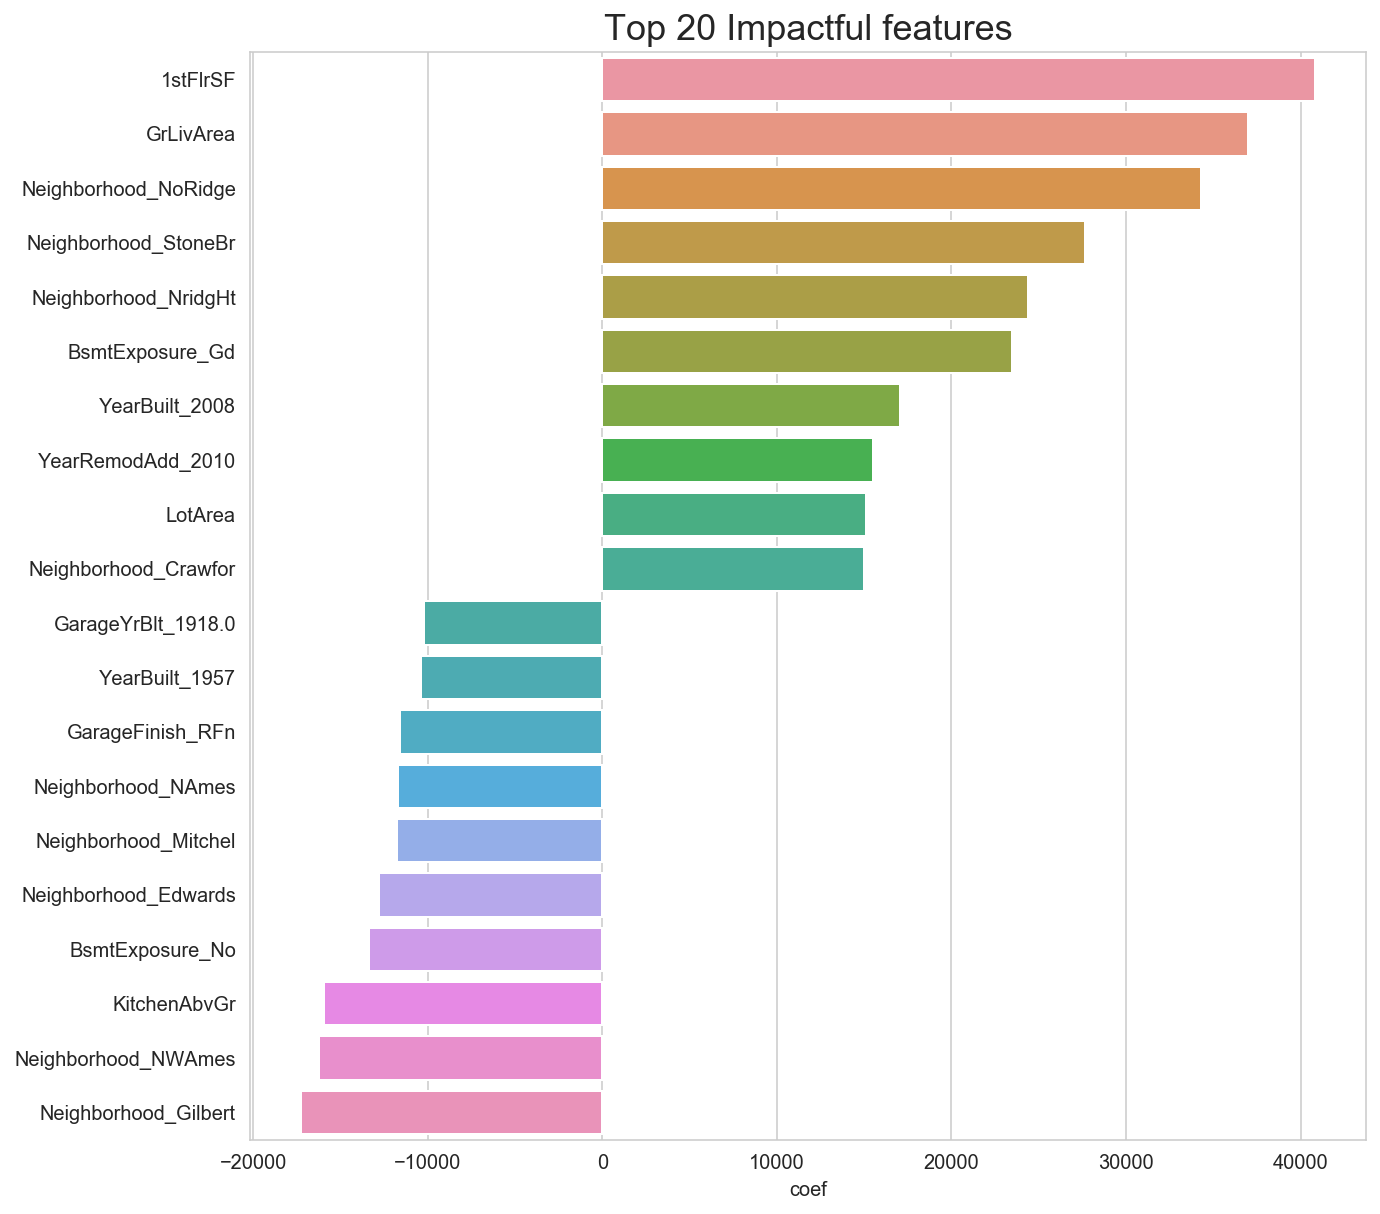

In [632]:
top_feature = pd.DataFrame(pd.concat([coef.head(10),coef.tail(10)]),columns=['coef'])
f ,ax = plt.subplots(figsize=(10,10))
sns.barplot(y=top_feature.index,x=top_feature['coef'])
plt.title('Top 20 Impactful features',fontdict={'fontsize': 18})

## Lasso

In [633]:
lasso = LassoCV(alphas=[0.01, 0.03,0.06,0.1,0.3,0.6, 1, 3 ,6 ,10 ,30 ,60])
model_lasso = lasso.fit(X_train,y_train)
y_pred_lasso=lasso.predict(X_test)
print("The R square of this model is {:.4f}".format(lasso.score(X_train,y_train)))
print("Mean square error is {:.4f}".format(mean_squared_error(y_test,y_pred_lasso)))

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3006355272.862488, tolerance: 493410742.63592553
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148007722255.3284, tolerance: 493410742.63592553
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151905091881.42038, tolerance: 493410742.63592553
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:5

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137317423673.37503, tolerance: 492666023.14907426
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153816307149.51794, tolerance: 492666023.14907426
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146237556319.7343, tolerance: 492666023.14907426
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

The R square of this model is 0.8902
Mean square error is 961052342.5047


/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166611975233.03494, tolerance: 545153158.9797182
  tol, rng, random, positive)
/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176057484398.1391, tolerance: 545153158.9797182
  tol, rng, random, positive)


## Model selection

In [634]:
# y_pred_lasso=inv_boxcox1p(y_pred_lasso,0)
# y_pred_ridge=inv_boxcox1p(y_pred_ridge,0)
# y_pred_lr=inv_boxcox1p(y_pred_lr,0)
# y_test=inv_boxcox1p(y_test,0)


In [583]:
result= pd.DataFrame(data= y_test)
result['PredictLasso']=y_pred_lasso
result['PredictRidge']=y_pred_ridge
result['PredictLinear']=y_pred_lr
result['ResidualLasso']=y_pred_lasso- y_test
result['ResidualRidge']=y_pred_ridge- y_test
result['ResidualLinear']=y_pred_lr- y_test

In [584]:
result

,SalePrice,PredictLasso,PredictRidge,PredictLinear,ResidualLasso,ResidualRidge,ResidualLinear
1023,inf,inf,inf,inf,NaN,NaN,NaN
381,inf,inf,inf,inf,NaN,NaN,NaN
843,inf,inf,inf,inf,NaN,NaN,NaN
427,inf,inf,inf,inf,NaN,NaN,NaN
192,inf,inf,inf,inf,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1417,inf,inf,inf,inf,NaN,NaN,NaN
788,inf,inf,inf,inf,NaN,NaN,NaN
1252,inf,inf,inf,inf,NaN,NaN,NaN
1191,inf,inf,inf,inf,NaN,NaN,NaN


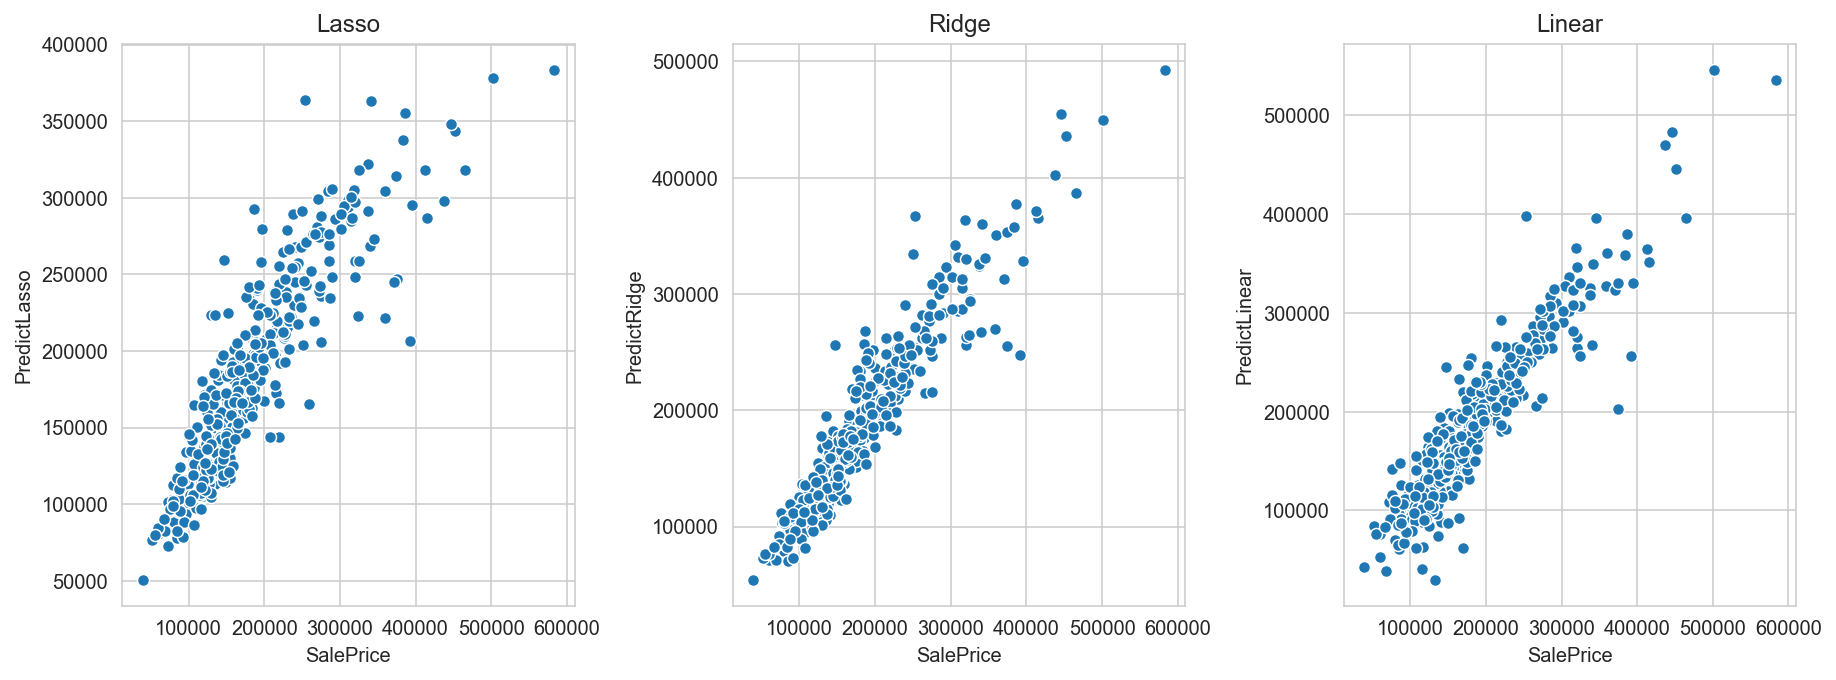

In [409]:
f ,ax = plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Lasso')
sns.scatterplot(x=result['SalePrice'],y=result['PredictLasso'])
plt.subplot(1,3,2)
plt.title('Ridge')
sns.scatterplot(x=result['SalePrice'],y=result['PredictRidge'])
plt.subplot(1,3,3)
plt.title('Linear')
sns.scatterplot(x=result['SalePrice'],y=result['PredictLinear'])
plt.subplots_adjust(wspace=0.35, bottom=0.1,hspace=0.2)

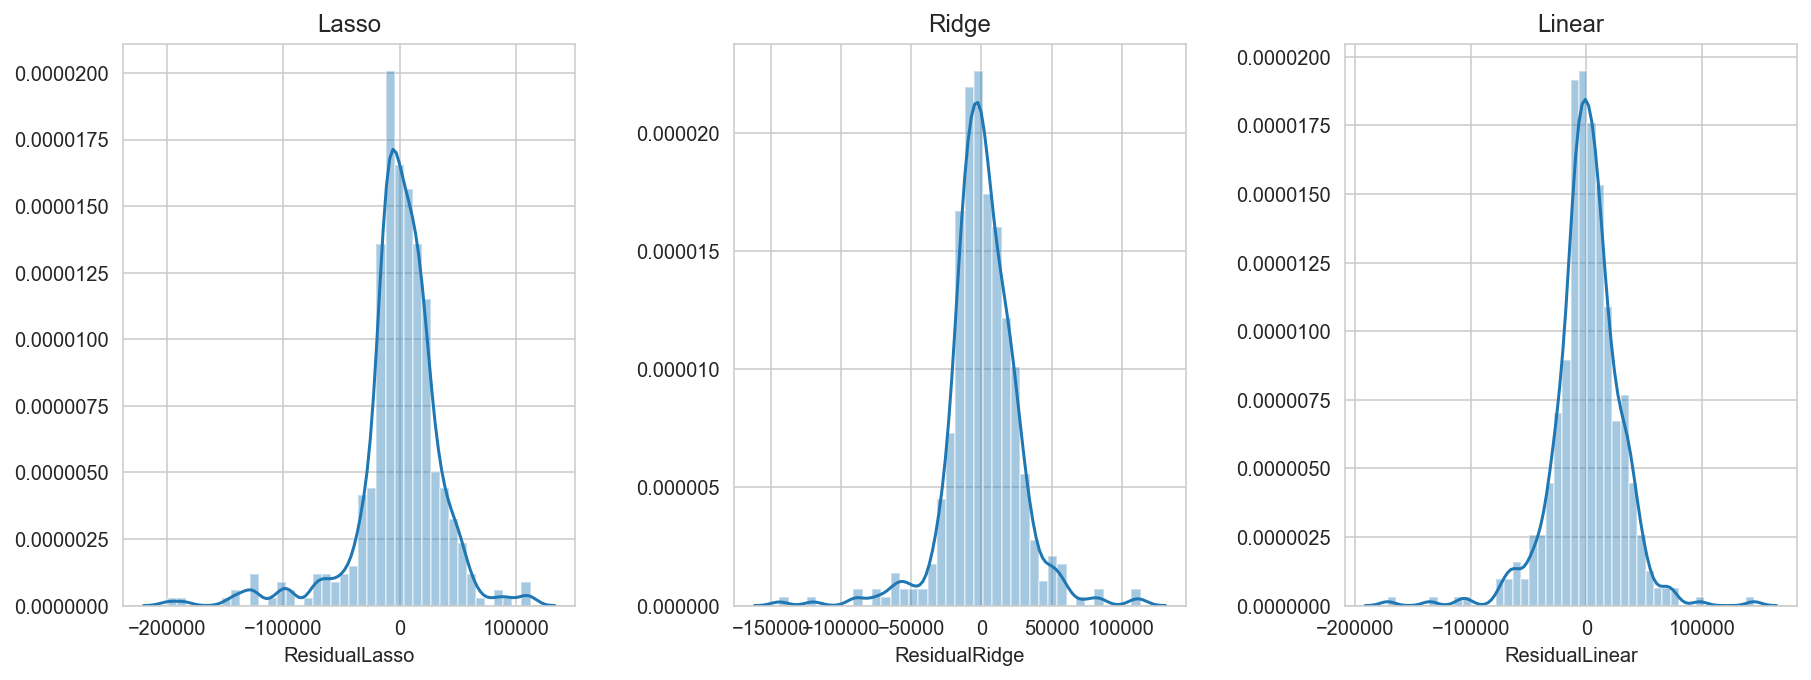

In [413]:
f ,ax = plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Lasso')
sns.distplot(result['ResidualLasso'])
plt.subplot(1,3,2)
plt.title('Ridge')
sns.distplot(result['ResidualRidge'])
plt.subplot(1,3,3)
plt.title('Linear')
sns.distplot(result['ResidualLinear'])
plt.subplots_adjust(wspace=0.35, bottom=0.1,hspace=0.2)

# 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [414]:
alphas = np.logspace(0, 5, 200)
ridge = RidgeCV(alphas=alphas, cv=10)
model_ridge = ridge.fit(X_train, y_train)
y_pred_ridge_test=ridge.predict(X_test)
y_pred_ridge_train=ridge.predict(X_train)